In [1]:
from glob import glob

directories = glob('text/*')
directories

['text/movie-enter',
 'text/it-life-hack',
 'text/kaden-channel',
 'text/topic-news',
 'text/livedoor-homme',
 'text/peachy',
 'text/sports-watch',
 'text/dokujo-tsushin',
 'text/CHANGES.txt',
 'text/README.txt',
 'text/smax']

In [2]:
txts = glob('text/*.txt')
txts

['text/CHANGES.txt', 'text/README.txt']

In [3]:
for txt in txts:
    directories.remove(txt)

directories

['text/movie-enter',
 'text/it-life-hack',
 'text/kaden-channel',
 'text/topic-news',
 'text/livedoor-homme',
 'text/peachy',
 'text/sports-watch',
 'text/dokujo-tsushin',
 'text/smax']

In [4]:
filepaths = glob('text/it-life-hack/*.txt')

filepath = filepaths[0]
filepath

'text/it-life-hack/it-life-hack-6793390.txt'

In [5]:
with open(filepath, encoding='utf-8') as f:
    text = ''.join(f.readlines()[2:])

text[:150]

'Ultrabookをパワーアップ！\u3000mSATA対応の小型SSDがマイクロンより登場\nマイクロンジャパンは、従来の「Crucial m4 SSD」の性能と信頼性をそのまま維持しつつも、1/8のサイズまで超小型化したSSD「Crucial m4 mSATA SSD」を発売する。最近流行のUltraboo'

In [6]:
from janome.tokenizer import Tokenizer
tagger = Tokenizer(wakati=True)

words = tagger.tokenize(text)
words[:10]

['Ultrabook', 'を', 'パワーアップ', '！', '\u3000', 'mSATA', '対応', 'の', '小型', 'SSD']

In [7]:
def preprocessing(filepath):
    with open(filepath, encoding='utf-8') as f:
        text = ''.join(f.readlines()[2:])
        text = text.replace('\u3000', '')
        text = text.replace('\n', '')
        words = tagger.tokenize(text)
    return words

In [8]:
words = preprocessing(filepath)
words[:10]

['Ultrabook', 'を', 'パワーアップ', '！', 'mSATA', '対応', 'の', '小型', 'SSD', 'が']

In [9]:
def labeling(directory):
    if 'it-life-hack' in directory or 'kaden-channel' in directory:
        return 1
    else:
        return 0

In [10]:
labeling('text/it-life-hack')

1

In [11]:
labeling('text/movie-enter')

0

In [12]:
word_collect, labels = [], []
for directory in directories:
    filepaths = glob(directory + '/*.txt')
    for filepath in filepaths:
        words = preprocessing(filepath)
        label = labeling(directory)
        word_collect.append(words)
        labels.append(label)

In [13]:
len(word_collect)

7376

In [14]:
from gensim import corpora, matutils

dictionary = corpora.Dictionary(word_collect)

In [15]:
n_words = len(dictionary)
n_words

76080

20回以上出現の単語に絞る

In [16]:
dictionary.filter_extremes(no_below=20)
n_words = len(dictionary)
n_words

9797

In [17]:
bow_ids = []
for words in word_collect:
    bow_id = dictionary.doc2bow(words)
    bow_ids.append(bow_id)

In [18]:
bows = matutils.corpus2dense(bow_ids,n_words).T

In [19]:
bows.shape

(7376, 9797)

In [20]:
import numpy as np

labels = np.array(labels, 'i')

(array([5640.,    0., 1736.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <a list of 3 Patch objects>)

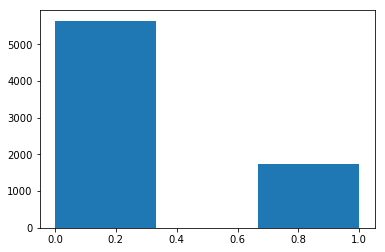

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(labels, bins=3)

In [22]:
weight = {
    0: len(labels) / len(labels[labels==0]),
    1: len(labels) / len(labels[labels==1])
}
weight

{0: 1.3078014184397162, 1: 4.248847926267281}

In [23]:
from sklearn.model_selection import train_test_split

x_train, x_test, t_train, t_test = train_test_split(bows, labels, test_size=0.3, random_state=0)

In [25]:
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((5163, 9797), (2213, 9797), (5163,), (2213,))

In [26]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(class_weight=weight, random_state=0)
clf.fit(x_train, t_train)

DecisionTreeClassifier(class_weight={0: 1.3078014184397162, 1: 4.248847926267281},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [27]:
clf.score(x_train, t_train)

1.0

In [28]:
clf.score(x_test, t_test)

0.9579755987347492

In [29]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

y_test = clf.predict(x_test)
precision_score(y_test, t_test)

0.9251439539347409

In [30]:
recall_score(y_test, t_test)

0.8992537313432836

In [31]:
matrix = confusion_matrix(t_test, y_test)
matrix

array([[1638,   54],
       [  39,  482]])

Text(33.0, 0.5, 'Target')

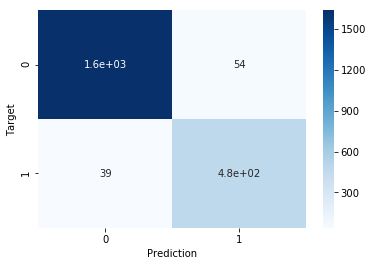

In [32]:
import seaborn as sns

sns.heatmap(matrix, annot=True, cmap='Blues');
plt.xlabel('Prediction')
plt.ylabel('Target')

In [33]:
from sklearn.model_selection import GridSearchCV

params = {
    "max_depth" : list(range(2, 5)),
    "criterion" : ["gini", "entropy"]
}

clf_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(class_weight=weight, random_state=0),
    scoring='precision',
    param_grid=params,
    cv=5,
)

clf_grid.fit(x_train, t_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight={0: 1.3078014184397162, 1: 4.248847926267281},
            criterion='gini', max_depth=None, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [2, 3, 4], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [34]:
clf_grid.best_params_

{'criterion': 'entropy', 'max_depth': 2}

In [35]:
clf = clf_grid.best_estimator_
clf

DecisionTreeClassifier(class_weight={0: 1.3078014184397162, 1: 4.248847926267281},
            criterion='entropy', max_depth=2, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=0, splitter='best')

In [40]:
clf.score(x_test, t_test)

0.8987799367374605

In [41]:
y_test = clf.predict(x_test)
precision_score(t_test, y_test)

0.9900990099009901

In [42]:
recall_score(t_test, y_test)

0.5758157389635317

In [43]:
matrix = confusion_matrix(t_test, y_test)
matrix

array([[1689,    3],
       [ 221,  300]])

Text(33.0, 0.5, 'Target')

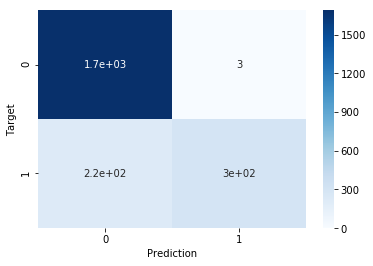

In [44]:
sns.heatmap(matrix, annot=True, cmap='Blues');
plt.xlabel('Prediction')
plt.ylabel('Target')

In [45]:
import joblib

joblib.dump(clf, 'document_classifier.pkl')

['document_classifier.pkl']

In [46]:
joblib.dump(dictionary, 'dictionary.pkl')

['dictionary.pkl']